# Final Training
This notebook contains the final training that is used in the analysis.

Set the name of this training, and the job number it is based on. This will keep the resulting output xml files seperate below.

In [1]:
jobId = 106
training_name = "full_event_grad1000"

## Initalization

In [2]:
from bdt_training_scikit_tools import load_trimmed_sample, default_training_variable_list, \
    test_train_samples, prep_samples, default_training, calc_performance, get_fraction_of_events
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools

In [3]:
training_file_stub = 'training_{0}_{1}'.format(jobId, training_name)

## Load data

In [4]:
%%time
input_events = load_trimmed_sample(jobId)

Job 106:
  BIB: 800000 events
  Multijet: 800000 events
  Signal: 800000 events
  [800000, 800000, 504190]
CPU times: user 9.89 s, sys: 1.48 s, total: 11.4 s
Wall time: 11.4 s


In [5]:
events_25 = get_fraction_of_events(input_events, 0.25)
print ([len(i.index) for i in events_25])

[201018, 200123, 126005]


In [6]:
events_to_use = input_events

## Training
Default training variables. Likely were arrived at by analysis in the Training Variables workbook.

In [7]:
training_variables = ['EnergyDensity',
 'BIBDeltaTimingM',
 'JetPt',
 'HadronicLayer1Fraction',
 'ShowerCenter',
 'JetLat',
 'FirstClusterRadius',
 'JetLong',
 'MaxTrackPt',
 'PredictedLxy',
 'BIBDeltaTimingP',
 'PredictedLz',
 'SumPtOfAllTracks']

Run the training to get a bdt back.

In [8]:
%%time
# Split into testing and training samples
train, test = test_train_samples(events_to_use)

# Prep samples for training
all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2], training_variable_list=training_variables)

CPU times: user 503 ms, sys: 447 ms, total: 950 ms
Wall time: 939 ms


In [9]:
%%time
bdt = default_training(all_events, training_weight, all_events_class)

CPU times: user 2h 51min 5s, sys: 1min 48s, total: 2h 52min 54s
Wall time: 2h 52min 54s


Calculate the performance for this training

In [10]:
%%time
calc_performance(bdt, input_events, training_variables=training_variables)

CPU times: user 52.8 s, sys: 938 ms, total: 53.8 s
Wall time: 53.6 s


{'BIBBack': 608645147.7366955,
 'BIBEff': 0.6479425,
 'BIBSsqrtB': 21.010886280389506,
 'BIBTotalCount': 800000,
 'BIBTotalWeight': 800000.0,
 'BIBinBIB': 518354.0,
 'BIBinHSS': 18624.0,
 'BIBinMJ': 263022.0,
 'HSSBack': 29150669.71553466,
 'HSSEff': 0.9860826275808723,
 'HSSSsqrtB': 92.08380721628399,
 'HSSTotalCount': 504190,
 'HSSTotalWeight': 504190.0,
 'HSSinBIB': 3428.0,
 'HSSinHSS': 497173.0,
 'HSSinMJ': 3589.0,
 'MJBack': 266611.0,
 'MJEff': 0.7440198465650026,
 'MJSsqrtB': 3590094.2006727965,
 'MJTotalCount': 800000,
 'MJTotalWeight': 2491496926.202851,
 'MJinBIB': 608641719.7366955,
 'MJinHSS': 29132045.71553466,
 'MJinMJ': 1853723160.7506208}

In [11]:
from sklearn.externals import joblib
joblib.dump(bdt, training_file_stub + '.pkl') 

['training_106_full_event_grad1000.pkl']

## Conversion to TMVA format

In [16]:
import mlglue
import mlglue.tree
from sklearn.externals import joblib
bdt1 = joblib.load(training_file_stub + '.pkl')
bdtGeneral = mlglue.tree.BDTsklearn(bdt1, list(all_events.columns), ['BIB', 'MJ', 'Signal'])
bdtGeneral.to_tmva(training_file_stub + ".xml")

norm is 1.0


## Performance
Look at some generic performance plots for the bdt.

In [17]:
perf_events, perf_events_class, perf_training_weight, perf_evaluation_weight = prep_samples(input_events[0], input_events[1], input_events[2], training_variable_list=training_variables)

In [18]:
predicted_class = bdt1.predict(perf_events)

Text(0.5,1,'HSS')

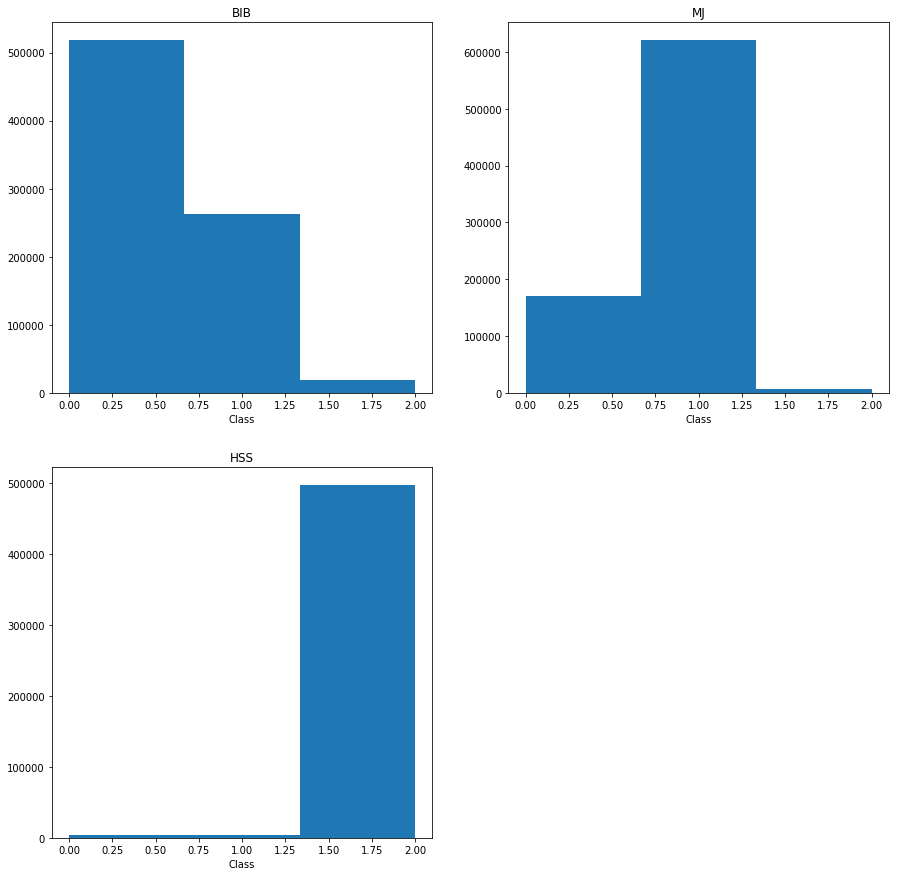

In [19]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot(221)
ax.hist(predicted_class[perf_events_class.Class == 0], bins=3)
ax.set_xlabel('Class')
ax.set_title('BIB')

ax = plt.subplot(222)
ax.hist(predicted_class[perf_events_class.Class == 1], bins=3)
ax.set_xlabel('Class')
ax.set_title('MJ')

ax = plt.subplot(223)
ax.hist(predicted_class[perf_events_class.Class == 2], bins=3)
ax.set_xlabel('Class')
ax.set_title('HSS')

In [20]:
predicted_prob = bdt1.predict_proba(perf_events)

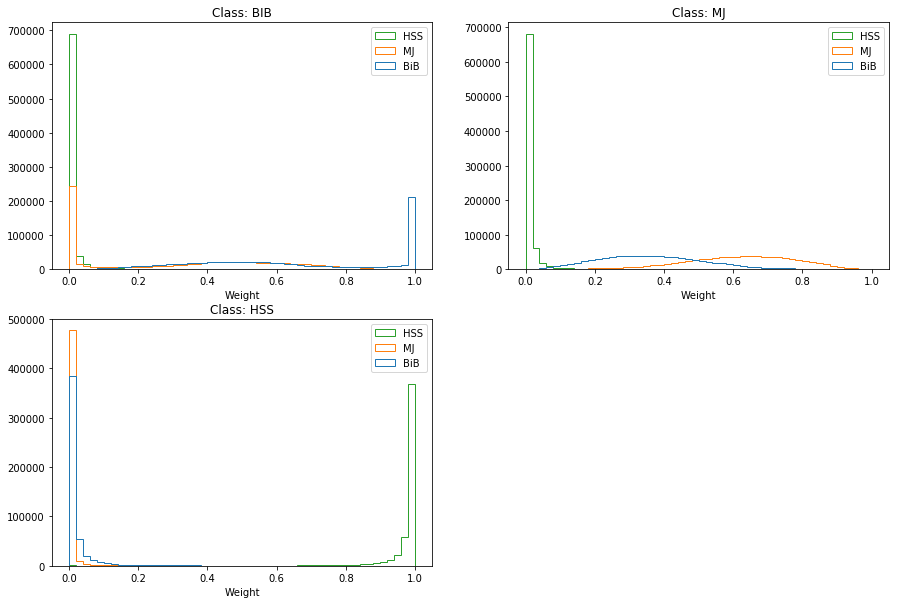

In [21]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(221)
ax.hist(predicted_prob[perf_events_class.Class == 0], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: BIB')
ax.legend()

ax = plt.subplot(222)
ax.hist(predicted_prob[perf_events_class.Class == 1], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: MJ')
ax.legend()

ax = plt.subplot(223)
ax.hist(predicted_prob[perf_events_class.Class == 2], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: HSS')
ax.legend()

## TMVA Cross Check
We always have trouble with that. We need to look to see what we can expect with TMVA. Below there is Bib, MJ, and Signal, all three classes. 5 events are taken (first jet pt eta phi are shown along with event number so they can be correlated with the real full root trees). The full inputs are shown, in the proper order to be fed to the bdt. Then the result of the TMVA translation is evaluated, and then the probabilities from the sklean classifier are shown. A direct match isn't expected, but the trents (e.g. signal has the class2 column always larger than the bib or mj columns).

### What is wrong with this translation?
I'm using a slightly modified version of mlglue to do the translation. Yet, as you can see below, the MJ, Sig, and background come out almost alike. And the classifier works rather well when it is run internally. So... what is going on?

### BiB (class 0)
First lets look at BiB. We'll get some absolute numbers out of the weight calculations

In [22]:
events_to_use[0][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
0,311170,927379924,191.9800,0.751230,1.51744
1,311170,933624178,129.4040,0.155269,-2.99099
2,311170,932123345,115.3560,-0.260263,3.09345
3,311170,929187568,155.0430,-0.640188,1.34265
4,311170,929187568,91.3555,0.247285,-2.10950


In [23]:
subsample = all_events[all_events_class.Class==0][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
0,0.001389,15.063000,191.9800,0.745036,1784.0,0.859375,3376,0.953125,0.0000,2052.750,0.503155,1810.120,0.0000
1,0.002548,0.652127,129.4040,0.991674,952.0,0.283203,2496,0.312500,0.0000,1897.490,-2.198750,447.772,0.0000
2,0.002991,-3.603590,115.3560,1.000830,948.0,0.886719,2528,0.355469,0.0000,1961.130,0.726138,686.700,0.0000
3,0.001686,4.304950,155.0430,0.610702,916.0,0.964844,2656,0.660156,53.6083,719.184,13.267500,455.200,102.2630
4,0.005402,7.480070,91.3555,0.306610,218.0,0.867188,1840,0.695312,14.9536,741.596,2.930280,156.224,28.8335


In [24]:
bdtGeneral.eval(subsample)

array([[0.34392826, 0.3253459 , 0.33072585],
       [0.35660276, 0.32849837, 0.31489886],
       [0.3537855 , 0.32864667, 0.31756782],
       [0.3402348 , 0.3399615 , 0.3198037 ],
       [0.34050807, 0.33893061, 0.32056133]])

In [25]:
bdt1.predict_proba(subsample)

array([[9.79234502e-01, 3.79434131e-03, 1.69711566e-02],
       [9.99724136e-01, 2.72417622e-04, 3.44601072e-06],
       [9.99352580e-01, 6.29712377e-04, 1.77076720e-05],
       [5.19311146e-01, 4.79766923e-01, 9.21931743e-04],
       [6.12988658e-01, 3.85738949e-01, 1.27239343e-03]])

### MultiJet (class 1)

Ok, now lets look at MJ, which is class 1. Note that the run number is not pulled correctly here. :(

In [26]:
events_to_use[1][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
0,284500,4157,46.9367,0.588283,-0.197074
1,284500,4160,58.6659,0.915437,0.622971
2,284500,4011,50.7740,0.682670,-0.738367
3,284500,4144,143.7050,0.985570,-1.977800
4,284500,4144,53.9551,-1.521310,-2.185010


In [27]:
subsample = all_events[all_events_class.Class==1][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
532865,0.000222,15.43420,46.9367,0.903034,952.0,0.722656,2704,0.839844,9.27670,637.783,5.24863,383.406,19.73200
532866,0.003311,14.31030,58.6659,0.570251,362.0,0.933594,2512,0.988281,2.38707,675.068,2.18954,577.785,3.81886
532867,0.004364,14.50810,143.7050,0.533774,251.0,0.886719,2512,0.917969,32.18010,655.481,1.97326,741.678,85.33030
532868,0.011231,1.26047,53.9551,0.213439,50.0,0.648438,3312,0.320312,3.21193,458.212,21.01740,938.516,3.21193
532869,0.006104,14.42450,49.4316,0.814982,246.0,0.519531,2432,0.718750,7.72666,698.374,2.70632,596.755,7.72666


In [28]:
bdtGeneral.eval(subsample)

array([[0.33522186, 0.33739651, 0.32738162],
       [0.3346404 , 0.33618432, 0.32917528],
       [0.33764369, 0.34254791, 0.3198084 ],
       [0.33459999, 0.33726547, 0.32813453],
       [0.33490673, 0.33778791, 0.32730536]])

In [29]:
bdt1.predict_proba(subsample)

array([[3.34139043e-01, 6.38638913e-01, 2.72220441e-02],
       [3.63139612e-01, 5.76081264e-01, 6.07791240e-02],
       [1.90911898e-01, 8.08359058e-01, 7.29043924e-04],
       [2.99668568e-01, 6.63345239e-01, 3.69861930e-02],
       [2.90246925e-01, 6.84373214e-01, 2.53798617e-02]])

### Signal (class 2)

Finally, lets look at signal

In [30]:
events_to_use[2][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
0,284500,11890,406.728,0.654438,-1.088650
2,284500,11752,208.314,0.965120,1.787220
3,284500,11681,160.882,-1.915340,-2.662330
4,284500,11197,218.932,0.832934,-0.486832
5,284500,11197,168.861,-1.907410,2.612810


In [31]:
subsample = all_events[all_events_class.Class==2][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
1066080,0.002594,21.44660,406.728,0.831321,1232.0,0.652344,3040,0.820312,0.0,2016.42,10.23040,1494.25,0.0
1066081,0.000660,36.55420,208.314,-0.001131,3936.0,0.371094,5440,0.322266,0.0,3293.99,8.81774,3404.06,0.0
1066082,0.005432,6.80703,160.882,0.151806,1064.0,0.777344,4992,0.820312,0.0,1043.40,38.70270,4139.80,0.0
1066083,0.001572,24.66940,218.932,0.724941,1296.0,0.488281,3296,0.832031,0.0,2106.88,10.13050,1962.46,0.0
1066084,0.009766,9.41108,168.861,0.043590,1120.0,0.371094,5088,0.025024,0.0,1269.28,41.90520,4506.63,0.0


In [32]:
bdtGeneral.eval(subsample)

array([[0.32986124, 0.32220857, 0.34793019],
       [0.32977475, 0.32205384, 0.34817142],
       [0.32655568, 0.32475412, 0.3486902 ],
       [0.33332614, 0.32460925, 0.34206461],
       [0.32940117, 0.32584119, 0.34475765]])

In [33]:
bdt1.predict_proba(subsample)

array([[5.52689720e-03, 5.29133045e-04, 9.93943970e-01],
       [5.02616679e-03, 4.70812044e-04, 9.94503021e-01],
       [1.62868437e-03, 9.37739564e-04, 9.97433576e-01],
       [7.92191369e-02, 5.60382566e-03, 9.15177037e-01],
       [1.18948765e-02, 4.01741274e-03, 9.84087711e-01]])

## Plots of TMVA Translation Performance

In [34]:
%%time
predicted_tmva_weights = bdtGeneral.eval(perf_events)

CPU times: user 4min 51s, sys: 3min 35s, total: 8min 27s
Wall time: 8min 27s


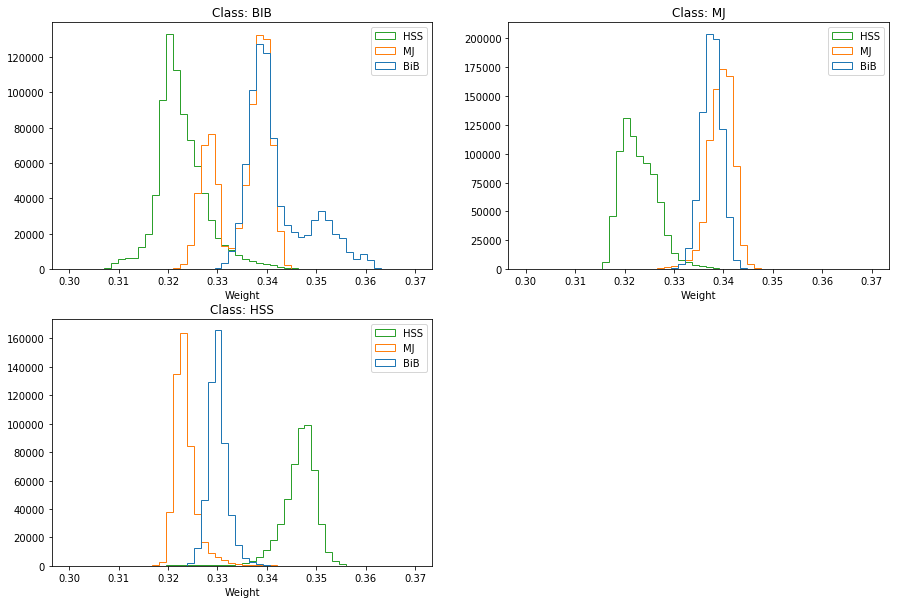

In [35]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(221)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 0], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step', range=[0.3, 0.37])
ax.set_xlabel('Weight')
ax.set_title('Class: BIB')
ax.legend()

ax = plt.subplot(222)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 1], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step', range=[0.3, 0.37])
ax.set_xlabel('Weight')
ax.set_title('Class: MJ')
ax.legend()

ax = plt.subplot(223)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 2], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step', range=[0.3, 0.37])
ax.set_xlabel('Weight')
ax.set_title('Class: HSS')
ax.legend()

Note in this version how everything is on top of itself. :(